<h1><center> Barcelona pass clustering with k-means
</center><h1>

In [4]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<h1>
1. Classes and game objects
    </h1>

In [5]:
class Pass:
    
    def __init__(self, team, start_loc, length, angle,  succesful):
        self.team = team
        self.start_loc = start_loc
        self.length = length
        self.angle = angle
        self.succesful = succesful
        

In [6]:
class Game:
    
    def __init__(self, json_file):
        
        self.json_file = json.loads(json_file)
        self.teams = []
    
    def get_passes(self, dataframe):
        
        all_passes = []
        data = self.json_file
        
        for i in range(len(data)):
            if data[i]['type']['name']=='Pass':
        
                successful_pass = not ('outcome' in data[i]['pass'].keys() )

                pass1 = Pass(data[i]['team']['name'], 
                             data[i]['location'], 
                             data[i]['pass']['length'], 
                             data[i]['pass']['angle'], 
                             successful_pass)
        
                all_passes.append(pass1)
            
        if dataframe:
            passes_df = pd.DataFrame( [[x.team, x.start_loc[0],x.start_loc[1], x.length, x.angle] 
                                         for x in all_passes] 
                                         )\
                        .reset_index(0).set_index([0,'index']).sort_index()
            
            passes_df.index.names = ["Team", "Passes nb"]
            passes_df.columns = ["Start x", "Start y","Length","Angle"]
        
            return passes_df
        
        return all_passes
    
    
 
    def plot_passes(self, team):
        
        plt.figure(figsize=(15,7))
        ax = plt.axes()
        plt.xlim(-5,125)
        plt.ylim(-5,85)

        for passes in self.get_passes(False):
            if passes.team == team:
                if passes.succesful:
                    color = 'green'
                else:
                    color = 'red'
        
                ax.arrow(passes.start_loc[0],passes.start_loc[1],
                     passes.length*np.cos(-passes.angle),
                     passes.length*np.sin(passes.angle),
                     fc= color , ec=color , head_width=2, head_length=1)
        

<h2>
1.1 Game objects
    </h2>

In [7]:
matches_list_11_12_url =  "https://github.com/statsbomb/open-data/blob/master/data/matches/11/21.json"

In [8]:
def fetch_matches_for_season(github_season_url):
    req = requests.get(github_season_url).text
    
    soup = BeautifulSoup(req, "lxml") 
    table = soup.find('table')
    
    game_nums = []
    for td in table.find_all('td'):
        if "match_id" in td.text:
            game_num = td.text[14:19]
            game_nums.append(game_num)
            
    json_files = []
    
    base_url_string = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/"
    
    game_num_dict = {
        game_num  : Game(requests.get(base_url_string + game_num + ".json").text)
        for game_num in game_nums
    }

        
    return game_num_dict
        
        

In [9]:
matches_11_12 = fetch_matches_for_season(matches_list_11_12_url)

In [12]:
matches_11_12['69239']

<h1>
2. Visualizing passing maps
    </h1>

In [11]:
matches_11_12['69239'].get_passes(True).loc["Barcelona"].head()

,Start x,Start y,Length,Angle
Passes nb,,,,
7,19.2,44.6,16.300306,0.933430
8,29.5,55.8,8.500000,-1.133458
9,34.6,48.1,17.601137,0.632138
13,6.0,36.0,31.975773,-0.712358
14,49.1,19.6,22.663185,-0.910527


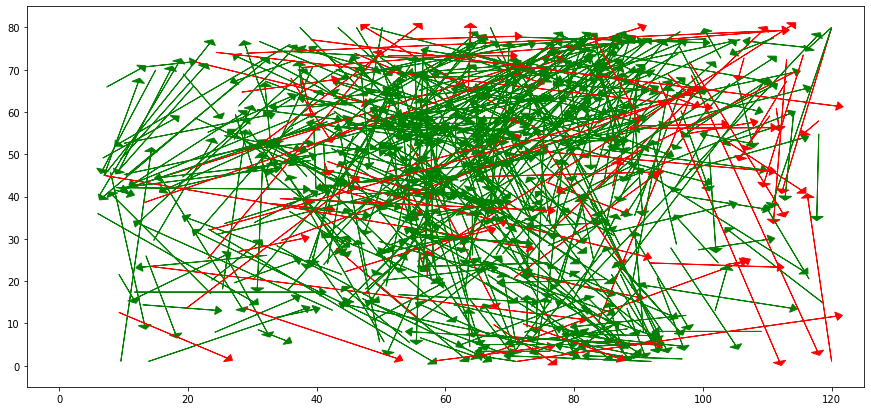

In [9]:
matches_11_12['69239'].plot_passes("Barcelona")

<h1> 
3. K-means clustering
    </h1>

<h2>
3.1 Data preprocessing
    </h2>

In [11]:
"""BARCELONA"""
barca_data_passing_11_12 = [matches_11_12[match].get_passes(True).loc["Barcelona"] for match in matches_11_12]
barca_data_passing = pd.concat(barca_data_passing_11_12)
barca_data_passing.index = range(len(barca_data_passing))

"""OTHER"""
other_data_passing_11_12 = [matches_11_12[match].get_passes(True).drop("Barcelona") for match in matches_11_12]
other_data_passing = pd.concat(other_data_passing_11_12)
other_data_passing.index = range(len(other_data_passing))

"ALL"
all_data_passing = pd.concat([barca_data_passing, other_data_passing])
all_data_passing.index = range(len(all_data_passing))

In [12]:
all_data_passing.head()

,Start x,Start y,Length,Angle
0,19.2,44.6,16.300306,0.933430
1,29.5,55.8,8.500000,-1.133458
2,34.6,48.1,17.601137,0.632138
3,6.0,36.0,31.975773,-0.712358
4,49.1,19.6,22.663185,-0.910527


In [13]:
scaler = StandardScaler()
scaler2 = MinMaxScaler()
barca_data_scaled = scaler.fit_transform(barca_data_passing)
other_data_scaled = scaler.fit_transform(other_data_passing)
#all_data_scaled = scaler.fit_transform(all_data_passing)
all_data_scaled = scaler2.fit_transform(all_data_passing)

<h2>
3.2 K-means 
    </h2>

<font size = 3><b><font color = 'black'>
Elbow method
    <b/></font>

In [909]:
"""
scores = []
n_clusters = range(1,65,1)

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(all_data_scaled)
    scores.append(-kmeans.score(all_data_scaled))
    
plt.plot(n_clusters, scores)
    
"""

'\nscores = []\nn_clusters = range(1,65,1)\n\nfor n in n_clusters:\n    kmeans = KMeans(n_clusters=n, random_state=0).fit(all_data_scaled)\n    scores.append(-kmeans.score(all_data_scaled))\n    \nplt.plot(n_clusters, scores)\n    \n'

<font size = 3><b><font color = 'black'>
Executing K-means
    <b/></font>

In [14]:
"""ALL DATA"""
kmeans1 = KMeans(n_clusters=81, random_state=40).fit(all_data_scaled)

In [15]:
all_data_passing_with_cluster = all_data_passing.copy()
all_data_passing_with_cluster['cluster'] = kmeans1.labels_+1

In [16]:
all_data_passing_with_cluster.head(10)

,Start x,Start y,Length,Angle,cluster
0,19.2,44.6,16.300306,0.933430,17
1,29.5,55.8,8.500000,-1.133458,67
2,34.6,48.1,17.601137,0.632138,35
3,6.0,36.0,31.975773,-0.712358,51
4,49.1,19.6,22.663185,-0.910527,58
5,30.3,20.7,34.209354,1.057451,71
6,42.7,60.2,11.112605,-0.829955,67
7,50.2,52.0,8.261961,0.905507,2
8,55.3,58.5,9.196738,-2.325435,20
9,50.5,56.9,5.178803,1.396124,2


<h2>
3.3 Plotting clusters
    </h2>

In [23]:
def plot_pass_clusters(clustered_passing_df, n_clusters):
    f1 = plt.figure(figsize=(25,20))
    f1.subplots_adjust(hspace=0.6)
    
    cmap = cm.get_cmap('jet')
    colors = ['blue','red','orange','green','purple','cyan','black','grey','blue','pink']
    n_passes_plot = 10
    
    for cluster in range(1,n_clusters+1):
    
        plt.subplot(9, 9, cluster)
        color = colors [ cluster %10 ] 
    
        for index in clustered_passing_df[clustered_passing_df["cluster"]==cluster].head(n_passes_plot).index:
        
            x_val =  clustered_passing_df.loc[index]["Start x"] 
            y_val =  clustered_passing_df.loc[index]["Start y"] 
            dx_val = clustered_passing_df.loc[index]["Length"]*np.cos(clustered_passing_df.loc[index]["Angle"])
            dy_val = clustered_passing_df.loc[index]["Length"]*np.sin(clustered_passing_df.loc[index]["Angle"]) 
    
            color = colors [ cluster %10 ] 
        
            plt.arrow(
                x= x_val, 
                y= y_val, 
                dx = dx_val,
                dy = dy_val,
                fc= color , 
                ec= color , 
                head_width=5, 
                head_length=2
            )
        
        plt.xlim(-5,125)
        plt.ylim(-5,85)
        plt.title(cluster)
     

<font size = 3><b><font color = 'black'>
All clusters
    <b/></font>

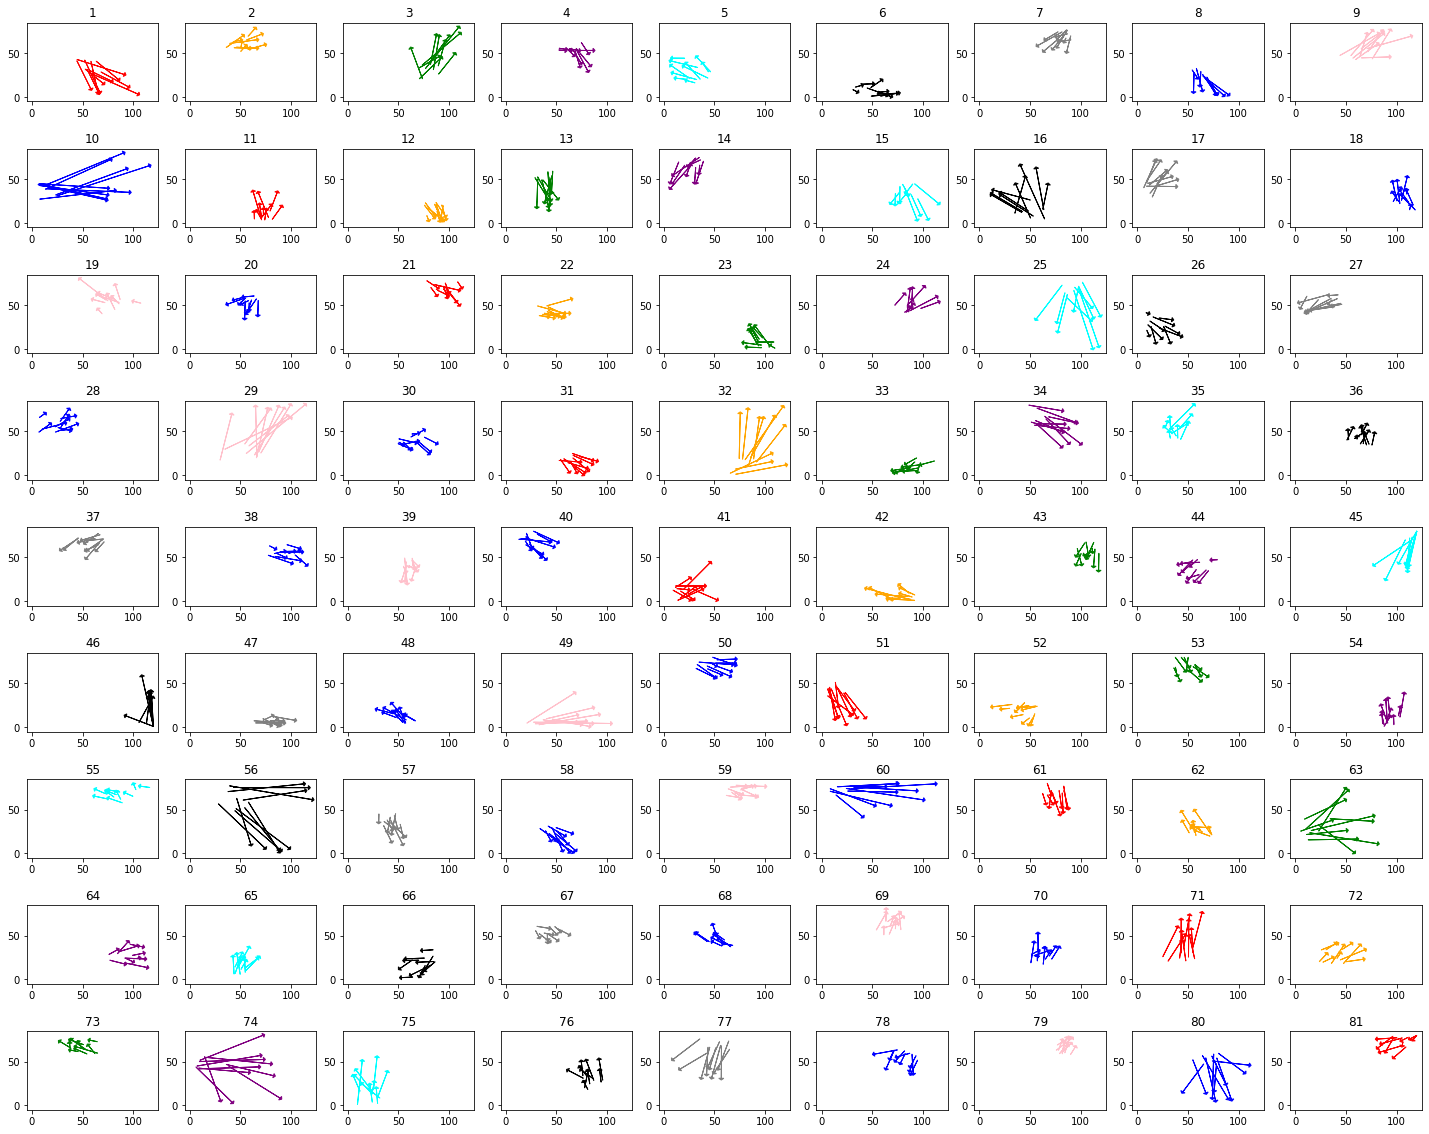

In [24]:
plot_pass_clusters(all_data_passing_with_cluster, n_clusters=81)

<h1>
4. Top clusters per team
    </h1>

In [106]:
def plot_cluster_percentages(all_data_with_clusters, barca_data, other_data ):
    "Barcelona"
    barca_data["cluster"] = all_data_with_clusters["cluster"]
    "Other"
    other_data.index = all_data_with_clusters.iloc[barca_data.shape[0]:]["cluster"].index
    other_data ["cluster"] = all_data_with_clusters["cluster"]
    
    barca_cluster_percentage = barca_data["cluster"].value_counts().to_frame() / barca_data.shape[0]*100
    other_cluster_percentage = other_data["cluster"].value_counts().to_frame() / other_data.shape[0]*100
    
    
    
    f1 = plt.figure(figsize=(30,18))
      
    plt.subplot(3,1,1) 
    plt.title("Barcelona", size = 22)
    plt.bar(barca_cluster_percentage.index, np.array(barca_cluster_percentage).flatten(),
       color = 'blue')
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=16)
    plt.ylabel("Percentage", size = 22, labelpad=10)

    plt.subplot(3,1,2) 
    plt.title("Others", size = 22)
    plt.bar(other_cluster_percentage.index, np.array(other_cluster_percentage).flatten(),
       color = "black")
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=16)
    plt.ylabel("Percentage", size = 22, labelpad=10)
    
    plt.subplot(3,1,3)
    
    p1 = barca_cluster_percentage
    q1 = 100-barca_cluster_percentage 
    n1 = barca_data["cluster"].value_counts().to_frame()

    p2 = other_cluster_percentage
    q2 = 100 - other_cluster_percentage
    n2 = other_data["cluster"].value_counts().to_frame()

    barca_cluster_diff = barca_cluster_percentage - other_cluster_percentage
    barca_cluster_diff["CI"] = np.sqrt(p1*q1/n1 + p2*q2/n2)
    
    plt.bar([str(x) for x in barca_cluster_diff.sort_values('cluster').index], 
        np.array(barca_cluster_diff.sort_values('cluster')["cluster"]).flatten(),
        #yerr=2*np.array(barca_cluster_diff.sort_values('CI')["CI"]).flatten(), 
        capsize=3,
        color = ['green' if y>0 else 'red' for y in barca_cluster_diff.sort_values('cluster')['cluster']])
    
    plt.xlabel("Cluster #", size = 22)
    plt.ylabel("Percentage difference", size = 22, labelpad=10)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=16)
    
    
    return barca_data, other_data, barca_cluster_percentage, other_cluster_percentage
    

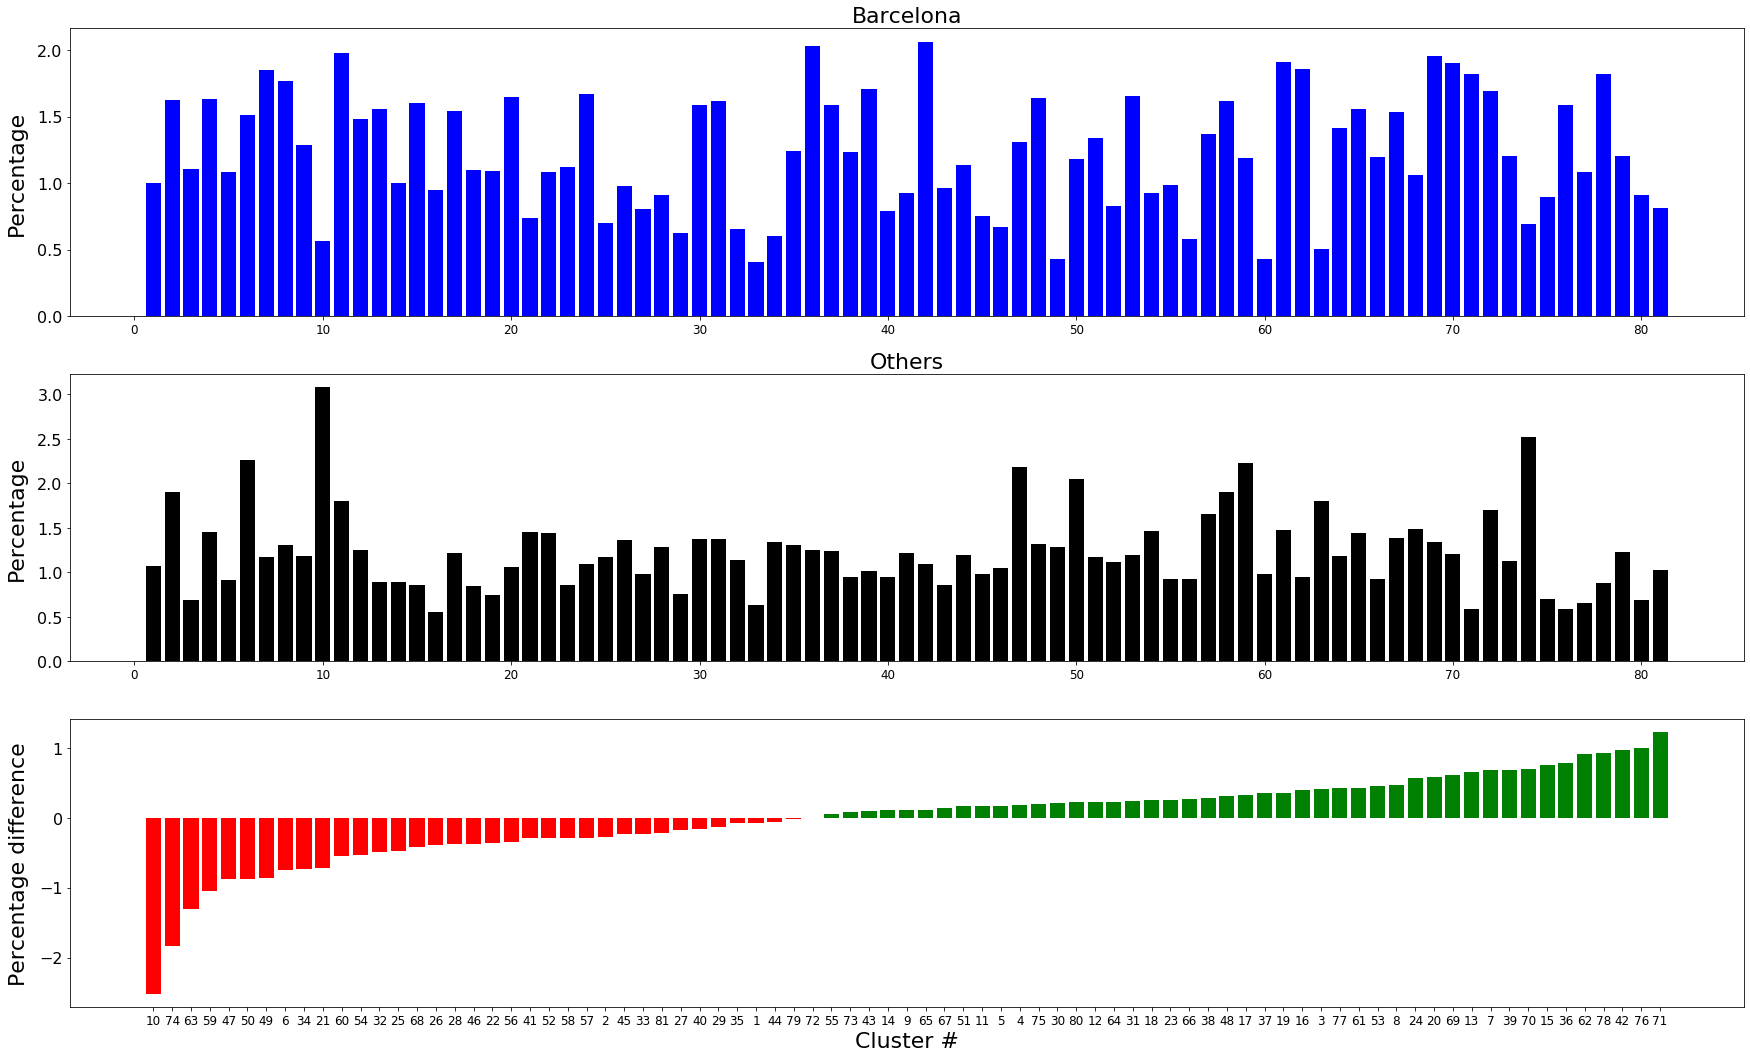

In [107]:
plot_cluster_percentages(all_data_passing_with_cluster, barca_data_passing, other_data_passing);